In [1]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)

# /home/coenraadmiddel/miniconda3/envs/venvRossmann
import os
import wget
from pathlib import Path

%load_ext autoreload
%autoreload 2



In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using {}".format(DEVICE))

Using cuda


In [3]:
path = '/home/coenraadmiddel/Documents/RossmannStoreSales/Input/'
trainset_name = 'rossman-store-sales'
path_train = path+'train.csv'
path_test = path+'test.csv'
path_store = path+'store.csv'

In [4]:
store = pd.read_csv(path_store)
store.fillna(0, inplace=True)

In [5]:
train = pd.read_csv(path_train, parse_dates=[2])
test = pd.read_csv(path_test, parse_dates=[2])
# test.fillna(value = 1, inplace = True)

/tmp/ipykernel_16225/614466905.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(path_train, parse_dates=[2])


In [6]:
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0
1112,1113,a,c,9260.0,0.0,0.0,0,0.0,0.0,0
1113,1114,a,c,870.0,0.0,0.0,0,0.0,0.0,0


In [7]:
# merge data with store 
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

# split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)
train = train.sort_values(['Date'], ascending = False)
train_total = train.copy()

split_index = 6*7*1115
valid = train[:split_index] 
train = train[split_index:]

# only use df of Sales > 0 and Open is 1
valid = valid[(valid.Open != 0)&(valid.Sales >0)]
train = train[(train.Open != 0)&(train.Sales >0)]
train_total = train_total[(train_total.Open != 0)&(train_total.Sales >0)]

In [8]:
np.log1p(train['Sales']).mean()

8.757394063459298

In [9]:
print(train.shape)
# print(valid.shape)

(804056, 18)


/tmp/ipykernel_16225/3068846701.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
/tmp/ipykernel_16225/3068846701.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g2 = sns.distplot(np.log1p(train['Sales']), 

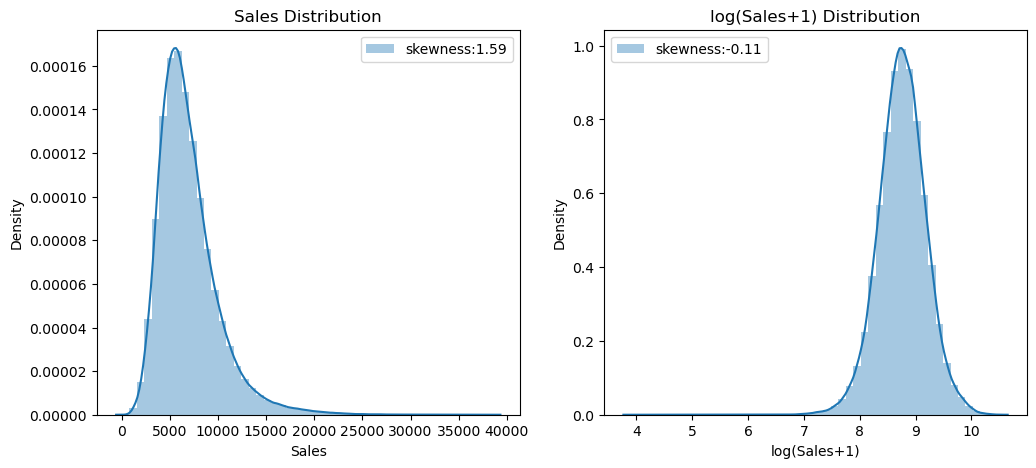

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# check distribution of sales in train set
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Sales', 

ylabel = 'Density', title = 'Sales Distribution')
g2 = sns.distplot(np.log1p(train['Sales']), hist = True,label='skewness:{:.2f}'.format(np.log1p(train['Sales']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Sales+1)',ylabel = 'Density', title = 'log(Sales+1) Distribution')
plt.show()

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804056 entries, 284584 to 238339
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      804056 non-null  int64         
 1   DayOfWeek                  804056 non-null  int64         
 2   Date                       804056 non-null  datetime64[ns]
 3   Sales                      804056 non-null  int64         
 4   Customers                  804056 non-null  int64         
 5   Open                       804056 non-null  int64         
 6   Promo                      804056 non-null  int64         
 7   StateHoliday               804056 non-null  object        
 8   SchoolHoliday              804056 non-null  int64         
 9   StoreType                  804056 non-null  object        
 10  Assortment                 804056 non-null  object        
 11  CompetitionDistance        804056 non-null  flo

In [12]:
train.head().T

,284584,417104,875290,119580,807974
Store,314,458,961,132,887
DayOfWeek,5,5,5,5,5
Date,2015-06-19 00:00:00,2015-06-19 00:00:00,2015-06-19 00:00:00,2015-06-19 00:00:00,2015-06-19 00:00:00
Sales,5032,7362,7764,7964,7776
Customers,562,688,768,692,632
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,0,0,0,0,0
StoreType,a,c,d,d,d


In [13]:
train["StateHoliday"].value_counts()

0    691026
0    112120
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [14]:


def process(data, isTest = False):
    # label encode some features - this does not work. fixing it below
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    # train.StoreType.replace(mappings, inplace=True)
    # train.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
        
    # extract some features from date column  
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    # calculate competiter open time in months
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
    # calculate promo2 open time in months
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
                                                 
    # Indicate whether the month is in promo interval
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month2str)

    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)    
    
    # select the features we need
    features = ['Store'
                , 'DayOfWeek'
                , 'Promo'
                , 'StateHoliday'
                , 'SchoolHoliday'
                , 'StoreType'
                , 'Assortment'
                , 'CompetitionDistance'
                , 'Promo2SinceWeek'
                , 'Promo2SinceYear'
                , 'Year'
                , 'Month'
                , 'Day'
                , 'WeekOfYear'
                , 'CompetitionOpen'
                , 'PromoOpen'
                , 'IsPromoMonth']  
    if not isTest:
        features.append('Sales')
      
       
    data = data[features]
    return data

In [15]:
train = process(train)

# sort by index
train.sort_index(inplace = True)
train_total.sort_index(inplace = True)


/tmp/ipykernel_16225/3753163766.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear


In [16]:
columns = train.columns.tolist()

In [17]:

def deterministic_processing(df):

    # df.drop('Sales', inplace=True, axis=1)
    df['ncol1'] = np.random.randint(0, 21, size=len(df))
    df['ncol2'] = np.random.randint(0, 21, size=len(df))
    df['ncol3'] = np.random.randint(0, 21, size=len(df))
    df['nnotcol4'] = np.random.randint(0, 21, size=len(df))
    df['cnotcol5'] = np.random.randint(0, 2, size=len(df))
    df['ccol6'] = np.random.randint(0, 2, size=len(df)) #categorcal testing

    #deterministic:
    df['Sales'] = df['ncol1'] * df['ncol2'] + df['ncol3']
    df['Sales'] = df.apply(lambda row: row['Sales'] * 2 if row['ccol6'] == 1 else row['Sales'], axis=1)
    
    return df


In [18]:
train = deterministic_processing(train)
# test = deterministic_processing(test)


In [19]:
train.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2SinceWeek,Promo2SinceYear,...,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,ncol1,ncol2,ncol3,nnotcol4,cnotcol5,ccol6
42,1,5,1,0,0,c,a,1270.0,0.0,0.0,...,81.0,24186.25,0,217,12,17,13,9,0,0
43,1,4,1,0,0,c,a,1270.0,0.0,0.0,...,81.0,24186.25,0,198,15,6,9,12,0,1
44,1,3,1,0,0,c,a,1270.0,0.0,0.0,...,81.0,24186.25,0,17,0,15,17,1,1,0
45,1,2,1,0,0,c,a,1270.0,0.0,0.0,...,81.0,24186.25,0,47,3,12,11,11,1,0
46,1,1,1,0,0,c,a,1270.0,0.0,0.0,...,81.0,24186.25,0,12,3,4,0,8,1,0


In [20]:
valid = process(valid)

valid = deterministic_processing(valid)

# sort by index
valid.sort_index(inplace = True)
# train_total.sort_index(inplace = True)

categorical_columns = ['Store',
                        'DayOfWeek',
                        'Promo',
                        'StateHoliday',
                        'SchoolHoliday',
                        'StoreType',
                        'Assortment',
                        # 'Year',
                        # 'Month',
                        # 'Day',
                        # 'WeekOfYear',
                        'IsPromoMonth',
                        'cnotcol5', 
                        'ccol6',
                        
                        ]
categorical_dims =  {}

for col in categorical_columns:
    print(col, valid[col].nunique())
    valid[col] = valid[col].astype(str)
    l_enc = LabelEncoder()
    # train[col] = train[col].fillna("VV_likely")
    valid[col] = l_enc.fit_transform(valid[col].values)
    # categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)
    
    
print(categorical_dims)

/tmp/ipykernel_16225/3753163766.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear


Store 1115
DayOfWeek 7
Promo 2
StateHoliday 1
SchoolHoliday 2
StoreType 4
Assortment 3
IsPromoMonth 2
cnotcol5 2
ccol6 2
{'Store': 1115, 'DayOfWeek': 7, 'Promo': 2, 'StateHoliday': 1, 'SchoolHoliday': 2, 'StoreType': 4, 'Assortment': 3, 'IsPromoMonth': 2, 'cnotcol5': 2, 'ccol6': 2}


In [21]:
X_valid_all, y_valid_all = valid.drop(columns = ['Sales']), np.log1p(valid[['Sales']])

In [22]:
train.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2SinceWeek,Promo2SinceYear,...,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,ncol1,ncol2,ncol3,nnotcol4,cnotcol5,ccol6
42,1,5,1,0,0,c,a,1270.0,0.0,0.0,...,81.0,24186.25,0,217,12,17,13,9,0,0
43,1,4,1,0,0,c,a,1270.0,0.0,0.0,...,81.0,24186.25,0,198,15,6,9,12,0,1
44,1,3,1,0,0,c,a,1270.0,0.0,0.0,...,81.0,24186.25,0,17,0,15,17,1,1,0
45,1,2,1,0,0,c,a,1270.0,0.0,0.0,...,81.0,24186.25,0,47,3,12,11,11,1,0
46,1,1,1,0,0,c,a,1270.0,0.0,0.0,...,81.0,24186.25,0,12,3,4,0,8,1,0


In [23]:
    
categorical_columns = ['Store',
                        'DayOfWeek',
                        'Promo',
                        'StateHoliday',
                        'SchoolHoliday',
                        'StoreType',
                        'Assortment',
                        # 'Year',
                        # 'Month',
                        # 'Day',
                        # 'WeekOfYear',
                        'IsPromoMonth',
                        'cnotcol5', 
                        'ccol6',
                        
                        ]

categorical_dims =  {}

for col in categorical_columns:
    print(col, train[col].nunique())
    train[col] = train[col].astype(str)
    l_enc = LabelEncoder()
    # train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    # categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)
    
    
print(categorical_dims)

Store 1115
DayOfWeek 7
Promo 2
StateHoliday 4
SchoolHoliday 2
StoreType 4
Assortment 3
IsPromoMonth 2
cnotcol5 2
ccol6 2
{'Store': 1115, 'DayOfWeek': 7, 'Promo': 2, 'StateHoliday': 4, 'SchoolHoliday': 2, 'StoreType': 4, 'Assortment': 3, 'IsPromoMonth': 2, 'cnotcol5': 2, 'ccol6': 2}


In [24]:
# split x and y
# X_all, y_all = train.drop(columns = ['Sales']), np.log1p(train[['Sales']])
X_all, y_all = train.drop(columns = ['Sales']), train[['Sales']]

In [25]:
train.describe()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2SinceWeek,Promo2SinceYear,...,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,ncol1,ncol2,ncol3,nnotcol4,cnotcol5,ccol6
count,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,...,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000
mean,557.669482,2.520532,0.447946,0.001489,0.186730,1.204881,0.936812,5445.036515,11.573756,1001.963511,...,7731.256875,12145.351147,0.168130,164.941408,10.005820,9.991742,10.009864,9.993988,0.499621,0.499919
std,321.741245,1.723856,0.497283,0.048754,0.389694,1.363172,0.993111,7806.454956,15.297096,1005.870346,...,11229.608674,12072.843590,0.373982,157.335594,6.050781,6.051270,6.057636,6.052642,0.500000,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,700.000000,0.000000,0.000000,...,28.000000,24.500000,0.000000,46.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000
50%,557.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2320.000000,0.000000,0.000000,...,90.000000,24156.250000,0.000000,114.000000,10.000000,10.000000,10.000000,10.000000,0.000000,0.000000
75%,837.000000,4.000000,1.000000,0.000000,0.000000,3.000000,2.000000,6880.000000,22.000000,2012.000000,...,24163.000000,24171.000000,0.000000,236.000000,15.000000,15.000000,15.000000,15.000000,1.000000,1.000000
max,1114.000000,6.000000,1.000000,3.000000,1.000000,3.000000,2.000000,75860.000000,50.000000,2015.000000,...,24186.000000,24186.250000,1.000000,840.000000,20.000000,20.000000,20.000000,20.000000,1.000000,1.000000


In [26]:
train.head().append(train.sample(5)).append(train.tail()).T.reset_index()

/tmp/ipykernel_16225/4293390566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train.head().append(train.sample(5)).append(train.tail()).T.reset_index()
/tmp/ipykernel_16225/4293390566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train.head().append(train.sample(5)).append(train.tail()).T.reset_index()


,index,42,43,44,45,46,81194,156182,120506,858060,581863,1017202,1017204,1017205,1017206,1017207
0,Store,0.00,0.00,0.00,0.00,0.00,993.0,198.0,154.00,1052.0,715.0,130.0,130.00,130.00,130.00,130.00
1,DayOfWeek,4.00,3.00,2.00,1.00,0.00,5.0,5.0,4.00,3.0,4.0,0.0,5.00,4.00,3.00,2.00
2,Promo,1.00,1.00,1.00,1.00,1.00,0.0,0.0,0.00,1.0,0.0,1.0,0.00,0.00,0.00,0.00
3,StateHoliday,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00
4,SchoolHoliday,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.00,0.0,1.0,1.0,1.00,1.00,1.00,1.00
5,StoreType,2.00,2.00,2.00,2.00,2.00,0.0,0.0,0.00,3.0,0.0,3.0,3.00,3.00,3.00,3.00
6,Assortment,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,2.0,0.0,2.0,2.00,2.00,2.00,2.00
7,CompetitionDistance,1270.00,1270.00,1270.00,1270.00,1270.00,2380.0,350.0,270.00,6860.0,7780.0,5350.0,5350.00,5350.00,5350.00,5350.00
8,Promo2SinceWeek,0.00,0.00,0.00,0.00,0.00,40.0,0.0,10.00,18.0,0.0,22.0,22.00,22.00,22.00,22.00
9,Promo2SinceYear,0.00,0.00,0.00,0.00,0.00,2014.0,0.0,2014.00,2011.0,0.0,2012.0,2012.00,2012.00,2012.00,2012.00


In [27]:
X_all_cats = X_all[categorical_columns]

In [28]:
X_all_cats.ccol6.value_counts()

0    402093
1    401963
Name: ccol6, dtype: int64

In [29]:
# make a list of the number of unique values in each categorical column

catmaxlist = [X_all_cats[col].nunique() for col in X_all_cats.columns]

In [30]:
catmaxlist

[1115, 7, 2, 4, 2, 4, 3, 2, 2, 2]

In [31]:
import random
random.seed(42)
target = 'Sales'
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 
print('Feartures to be used', features)

cat_dims = [X_all_cats[x].nunique() for x in X_all_cats.columns]
print(cat_dims)

# define your embedding sizes : here just a random choice
cat_emb_dim =  [random.randint(2, min(x, 10)) for x in catmaxlist]
print(cat_emb_dim)
print("Categorical Dimensions: ", len(cat_dims))
print("Categorical Embedding Dimensions: ", len(cat_emb_dim))
assert len(cat_dims) == len(cat_emb_dim)

print("Number of categorical features and embedding dimensions must be equal")


Feartures to be used ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth', 'ncol1', 'ncol2', 'ncol3', 'nnotcol4', 'cnotcol5', 'ccol6']
[1115, 7, 2, 4, 2, 4, 3, 2, 2, 2]
[3, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Categorical Dimensions:  10
Categorical Embedding Dimensions:  10
Number of categorical features and embedding dimensions must be equal


In [32]:
if "Set" not in train.columns:
    train.reset_index(inplace=True, drop=True)
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [33]:
train_indices.shape

(643293,)

In [34]:
X_all.values[train_indices].shape

(643293, 23)

In [35]:
X_train = X_all.values[train_indices]
y_train = y_all.values[train_indices].reshape(-1, 1)

X_valid = X_all.values[valid_indices]
y_valid = y_all.values[valid_indices].reshape(-1, 1)

X_test = X_all.values[test_indices]
y_test = y_all.values[test_indices].reshape(-1, 1)

In [47]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,804056.0,557.669482,321.741245,0.0,280.0,557.00,837.0,1114.00
DayOfWeek,804056.0,2.520532,1.723856,0.0,1.0,2.00,4.0,6.00
Promo,804056.0,0.447946,0.497283,0.0,0.0,0.00,1.0,1.00
StateHoliday,804056.0,0.001489,0.048754,0.0,0.0,0.00,0.0,3.00
SchoolHoliday,804056.0,0.186730,0.389694,0.0,0.0,0.00,0.0,1.00
StoreType,804056.0,1.204881,1.363172,0.0,0.0,0.00,3.0,3.00
Assortment,804056.0,0.936812,0.993111,0.0,0.0,0.00,2.0,2.00
CompetitionDistance,804056.0,5445.036515,7806.454956,0.0,700.0,2320.00,6880.0,75860.00
Promo2SinceWeek,804056.0,11.573756,15.297096,0.0,0.0,0.00,22.0,50.00
Promo2SinceYear,804056.0,1001.963511,1005.870346,0.0,0.0,0.00,2012.0,2015.00


In [37]:
train['Day'].value_counts()

11    29006
4     28357
13    28148
5     28139
12    28132
2     28119
16    28090
18    27945
19    27388
7     27243
28    27220
27    27042
10    27042
17    27040
23    27012
8     26845
15    26707
6     26452
14    26160
21    26139
9     25953
24    25930
20    25889
22    25760
26    25020
25    24836
30    24096
3     23942
29    21343
1     18251
31    14810
Name: Day, dtype: int64

In [38]:
#get categorical feature indexes 

cat_idxs = [X_all.columns.get_loc(c) for c in categorical_columns if c in X_all]


In [39]:
print('Building model...')
print('Number of features: {}'.format(X_train.shape[1]))
print('Number of training samples: {}'.format(X_train.shape[0]))
print('Number of categorical features: {}'.format(len(cat_dims)))
print('Cat_dims: {}'.format(cat_dims))
print('Indexes of categorical features: {}'.format(cat_idxs))
print('List of categorical features and their embedding dimensions: {}'.format(list(zip(X_all_cats.columns, cat_emb_dim))))



Building model...
Number of features: 23
Number of training samples: 643293
Number of categorical features: 10
Cat_dims: [1115, 7, 2, 4, 2, 4, 3, 2, 2, 2]
Indexes of categorical features: [0, 1, 2, 3, 4, 5, 6, 16, 21, 22]
List of categorical features and their embedding dimensions: [('Store', 3), ('DayOfWeek', 2), ('Promo', 2), ('StateHoliday', 2), ('SchoolHoliday', 2), ('StoreType', 2), ('Assortment', 2), ('IsPromoMonth', 2), ('cnotcol5', 2), ('ccol6', 2)]


wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-keyring_1.0-1_all.deb

sudo dpkg -i cuda-keyring_1.0-1_all.deb


In [40]:
torch.cuda.is_available()

True

In [41]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using {}".format(DEVICE))

clf = TabNetRegressor(cat_dims=cat_dims
                      , cat_emb_dim=cat_emb_dim
                      , cat_idxs=cat_idxs
                      , device_name = DEVICE
                      , optimizer_params=dict(lr=1e-3
                                                # weight_decay=opt.weight_decay,``
                                                # beta_1=opt.beta_1,
                                                # beta_2=opt.beta_2,
                                                ),
                          scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
)

Using cuda


/home/coenraadmiddel/Documents/RossmannStoreSales/TabNet/tabnet/pytorch_tabnet/abstract_model.py:80: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [42]:
max_epochs = 200 if not os.getenv("CI", False) else 2
print(max_epochs)

200


In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(643293, 23)
(643293, 1)
(80180, 23)
(80180, 1)


In [49]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=25,
    batch_size=256,
    virtual_batch_size=128,
    # num_workers=0,
    # drop_last=False,
    # augmentations=aug, #aug
) 

epoch 0  | loss: 18833.97695| train_rmsle: 0.15532 | orig_train_rmsle: 0.15532 | train_mae: 13.82699| orig_train_mae: 13.82699| train_rmse: 22.48734| orig_train_rmse: 22.48734| train_mse: 505.68036| orig_train_mse: 505.68036| valid_rmsle: 0.15203 | orig_valid_rmsle: 0.15203 | valid_mae: 13.84574| orig_valid_mae: 13.84574| valid_rmse: 22.60009| orig_valid_rmse: 22.60009| valid_mse: 510.76414| orig_valid_mse: 510.76414|  0:01:35s
epoch 1  | loss: 395.58523| train_rmsle: 0.0873  | orig_train_rmsle: 0.0873  | train_mae: 9.45795 | orig_train_mae: 9.45795 | train_rmse: 15.27585| orig_train_rmse: 15.27585| train_mse: 233.35155| orig_train_mse: 233.35155| valid_rmsle: 0.08456 | orig_valid_rmsle: 0.08456 | valid_mae: 9.48719 | orig_valid_mae: 9.48719 | valid_rmse: 15.26423| orig_valid_rmse: 15.26423| valid_mse: 232.99673| orig_valid_mse: 232.99673|  0:03:10s
epoch 2  | loss: 270.48972| train_rmsle: 0.07225 | orig_train_rmsle: 0.07225 | train_mae: 4.85413 | orig_train_mae: 4.85413 | train_rmse: 

/home/coenraadmiddel/Documents/RossmannStoreSales/TabNet/tabnet/pytorch_tabnet/callbacks.py:173: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Save model and load

In [ ]:
# save tabnet model
saving_path_name = "./models/determined_model/"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./models/determined_model/.zip


In [ ]:
preds_valid = clf.predict(X_valid)

valid_mse = mean_squared_error(y_valid, preds_valid)

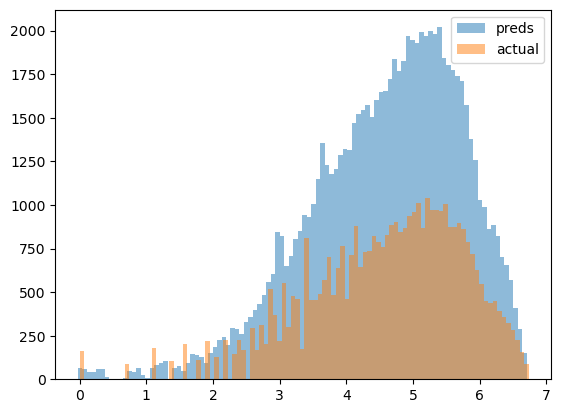

FINAL OUT OF TIME SCORE FOR rossman-store-sales : 0.0016778910314704345


In [ ]:
#Plot actual vs predicted in bins for validation set

plt.hist(preds_valid, 100, alpha=0.5, label='preds')
plt.hist(y_valid_all, 100, alpha=0.5, label='actual')
plt.legend(loc='upper right')
plt.show()

print(f"FINAL OUT OF TIME SCORE FOR {trainset_name} : {valid_mse}")



In [ ]:
# if loaded_cl
preds = clf.predict(X_test)
test_mse = mean_squared_error(preds, y_test)
# else:
loaded_preds = clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR {trainset_name} : {loaded_test_mse}")
print(f"FINAL TEST SCORE FOR {trainset_name} : {test_mse}")

FINAL TEST SCORE FOR rossman-store-sales : 0.0016516238873988626
FINAL TEST SCORE FOR rossman-store-sales : 0.0016516238873988626


# Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

array([0.00000000e+00, 9.72973993e-02, 8.22705165e-03, 9.82789564e-02,
       1.79129875e-07, 2.69390751e-04, 3.08630676e-05, 1.35573040e-02,
       9.56627922e-03, 5.68353822e-02, 4.79688960e-02, 7.26711105e-03,
       5.83743087e-05, 1.06416633e-05, 9.15702587e-03, 4.14648359e-03,
       0.00000000e+00, 1.96262924e-01, 1.83637814e-01, 0.00000000e+00,
       2.19411269e-03, 0.00000000e+00, 2.65233812e-01])

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
explain_matrix

array([[0.        , 0.60329807, 0.        , ..., 0.        , 0.        ,
        2.17587447],
       [0.        , 0.84044337, 0.        , ..., 0.        , 0.        ,
        3.10417032],
       [0.        , 1.02854908, 0.        , ..., 0.        , 0.        ,
        1.65743411],
       ...,
       [0.        , 0.69045228, 0.        , ..., 0.        , 0.        ,
        2.36288643],
       [0.        , 1.11257076, 0.        , ..., 0.        , 0.        ,
        1.87720644],
       [0.        , 1.26779568, 0.        , ..., 0.        , 0.        ,
        2.63061762]])

In [ ]:
masks

{0: array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.38667893, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.43403816, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.76095366, 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 1: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 2: array([[0.        , 0.20143366, 0.        , ..., 0.        , 0.        ,
         0.72649723],
        [0.        , 0.19866604, 0.        , ..., 0.   

In [ ]:
X_test.shape

(80583, 23)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
explain_matrix.shape

(80583, 23)

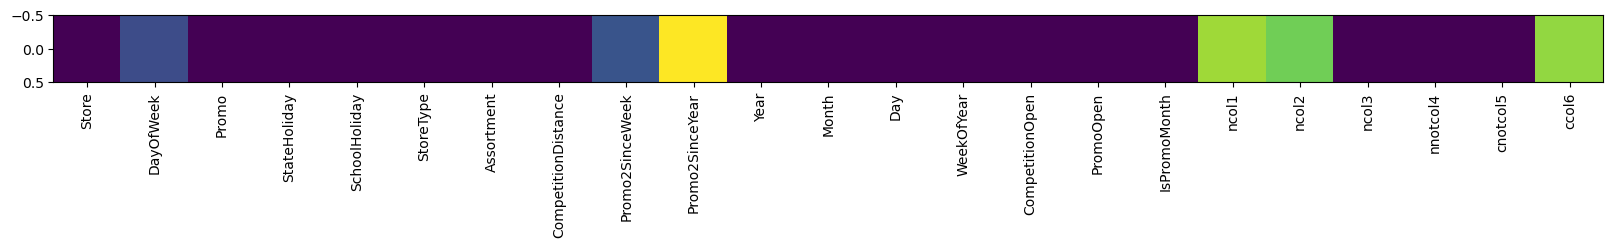

[0]


In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_xticks([x for x in range(len(X_all.columns))])
ax.set_xticklabels([x for x in X_all.columns], rotation=90)

prev_val = explain_matrix[0][0] # set initial previous value
sampled_rows = [explain_matrix[0]] # set initial sampled row
for row in explain_matrix[1:]: # loop through remaining rows starting from the second row
    curr_val = row[0]
    if abs(curr_val - prev_val) > 0.005: # or any other threshold value you choose
        sampled_rows.append(row)
        if len(sampled_rows) == 100: # break out of loop after 100 rows have been sampled
            break
    prev_val = curr_val

ax.imshow(sampled_rows)
plt.show()


#Get the row from X_all
X_all.iloc[



In [ ]:
explain_matrix_sorted = np.sort(explain_matrix, axis=0)

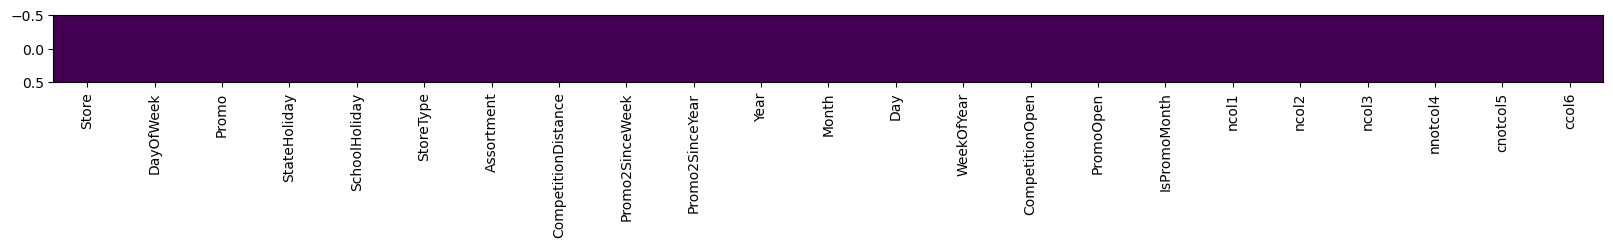

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_xticks([x for x in range(len(X_all.columns))])
ax.set_xticklabels([x for x in X_all.columns], rotation=90)

prev_val = explain_matrix_sorted[0][0] # set initial previous value
sampled_rows = [explain_matrix_sorted[0]] # set initial sampled row
for row in explain_matrix_sorted[1:]: # loop through remaining rows starting from the second row
    curr_val = row[0]
    if abs(curr_val - prev_val) > 0.005: # or any other threshold value you choose
        sampled_rows.append(row)
        if len(sampled_rows) == 100: # break out of loop after 100 rows have been sampled
            break
    prev_val = curr_val

ax.imshow(sampled_rows)
plt.show()


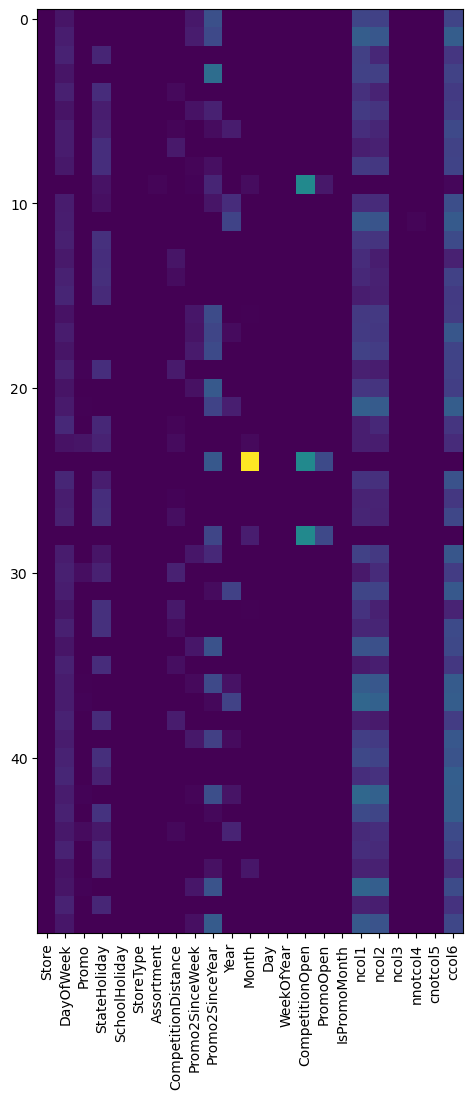

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_xticks([x for x in range(len(X_all.columns))])
ax.set_xticklabels([x for x in X_all.columns], rotation=90)
ax.imshow(explain_matrix[:50])
plt.show()

In [ ]:
X_all.shape

(804056, 23)

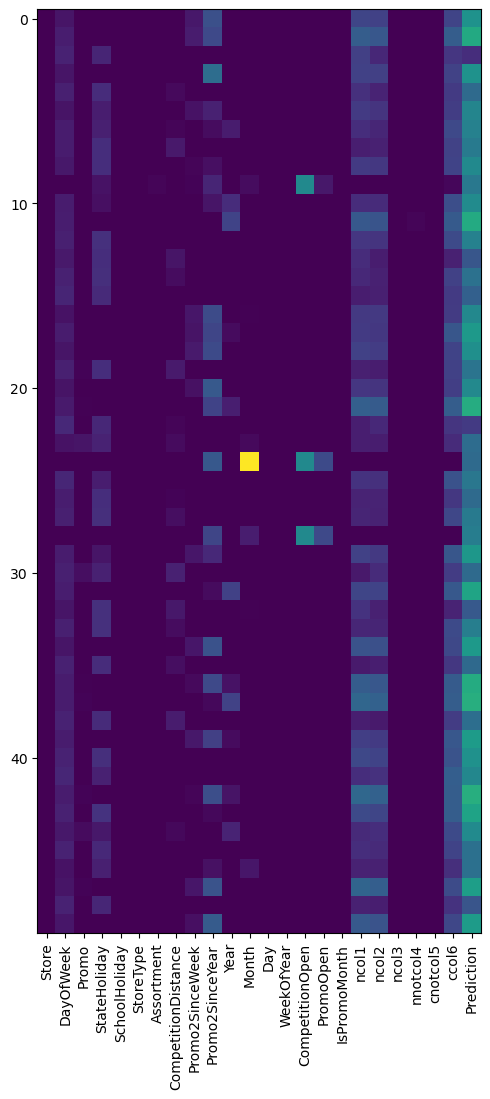

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_xticks([x for x in range(len(X_all.columns)+1)])
ax.set_xticklabels([x for x in X_all.columns] + ['Prediction'], rotation=90)
ax.imshow(np.append(explain_matrix[:50], y_test[:50].reshape(-1,1), axis=1))
plt.show()

In [ ]:
print(explain_matrix.shape)

(80583, 23)


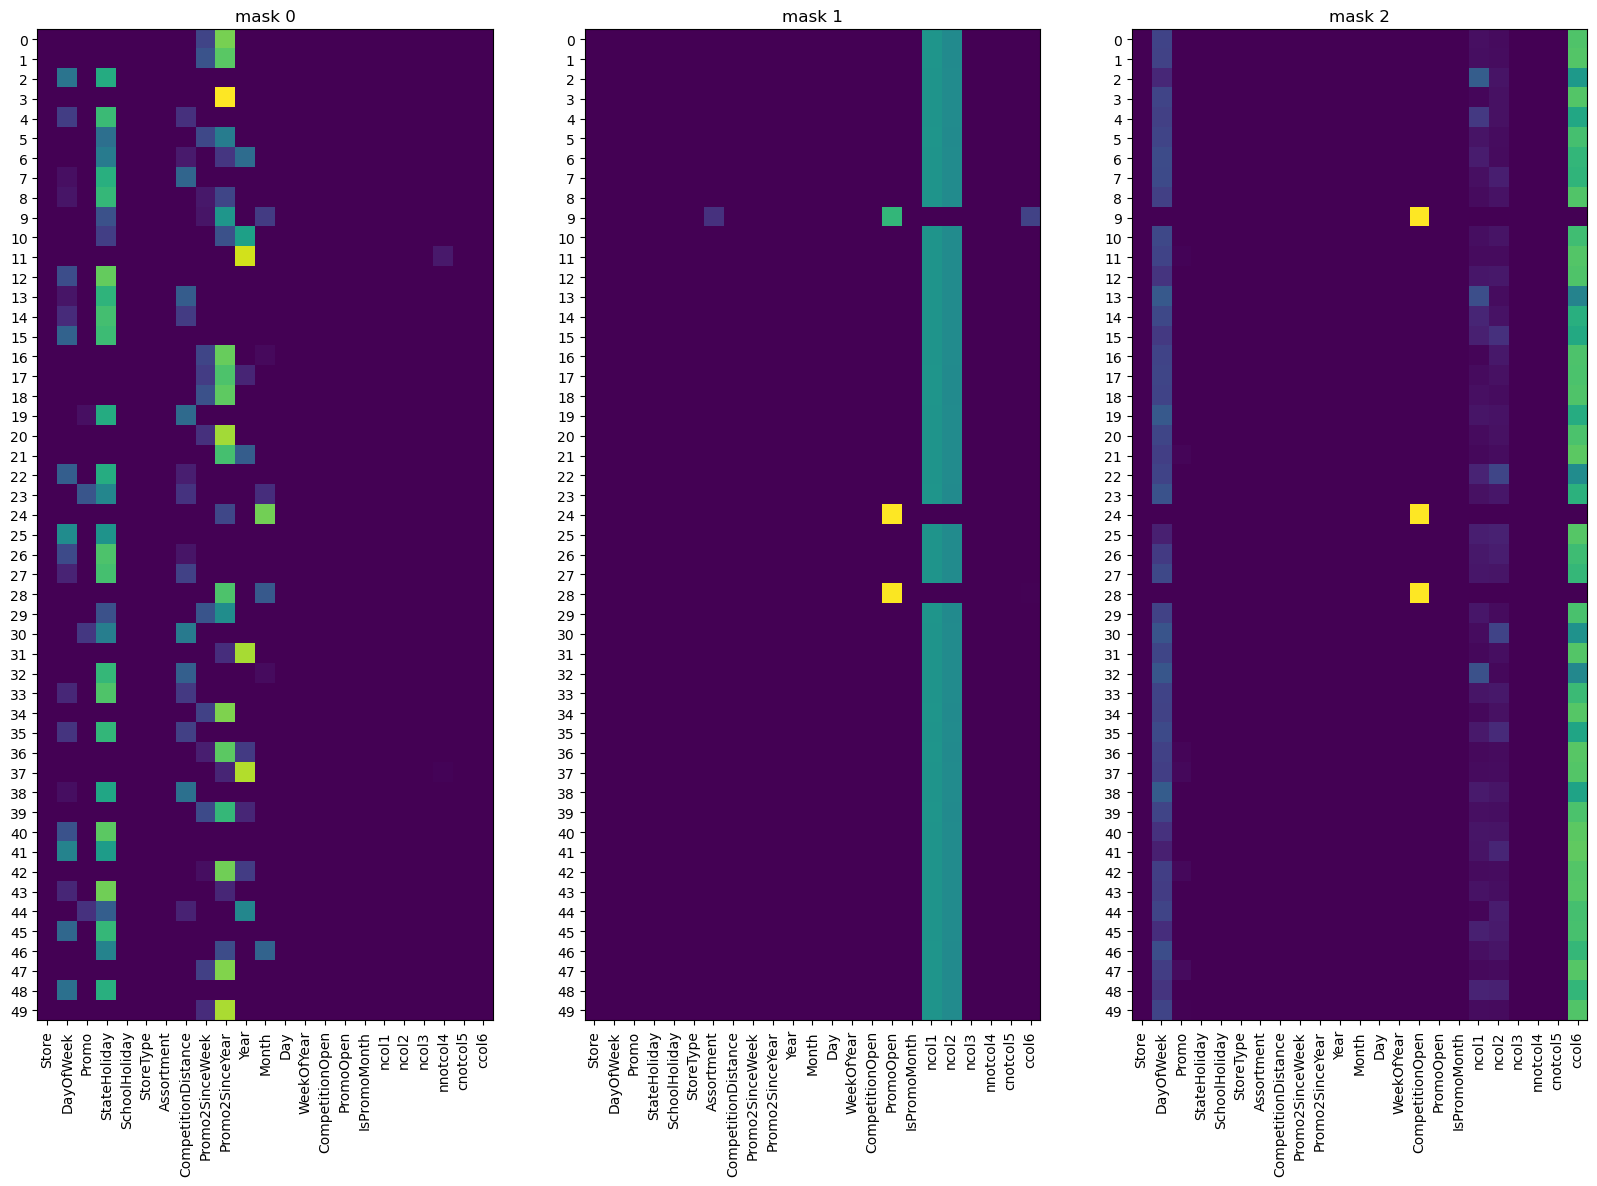

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticks([x for x in range(len(X_all.columns))])
    axs[i].set_xticklabels([x for x in X_all.columns], rotation=90)
    #show all yticks
    axs[i].set_yticks([x for x in range(len(masks[i][:50]))])
    


#Can we sort this? 
#By feature importance and then weight for mask? #TODO



In [88]:
preds.shape

(80583,)

In [91]:
y_test.shape

(80583, 1)

In [86]:
(19 * 19 + 19) * 2

760

In [85]:
print(X_all.iloc[24])
print(y_all.iloc[24])
#y in the original scale
print(np.expm1(y_all.iloc[24]))

Store                      0.00
DayOfWeek                  2.00
Promo                      1.00
StateHoliday               0.00
SchoolHoliday              0.00
StoreType                  2.00
Assortment                 0.00
CompetitionDistance     1270.00
Promo2SinceWeek            0.00
Promo2SinceYear            0.00
Year                    2015.00
Month                      5.00
Day                       20.00
WeekOfYear                21.00
CompetitionOpen           80.00
PromoOpen              24185.25
IsPromoMonth               0.00
ncol1                     19.00
ncol2                     19.00
ncol3                     19.00
nnotcol4                  12.00
cnotcol5                   0.00
ccol6                      1.00
Name: 72, dtype: float64
Sales    6.634633
Name: 72, dtype: float64
Sales    760.0
Name: 72, dtype: float64


In [72]:
len([x for x in X_all.columns])

23

# XGB

In [73]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

/home/coenraadmiddel/miniconda3/envs/venvTabBench/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[0]	validation_0-rmse:3.82699
[10]	validation_0-rmse:1.33697
[20]	validation_0-rmse:0.46771
[30]	validation_0-rmse:0.16410
[40]	validation_0-rmse:0.05828
[50]	validation_0-rmse:0.02209
[60]	validation_0-rmse:0.01088
[70]	validation_0-rmse:0.00795
[80]	validation_0-rmse:0.00716
[90]	validation_0-rmse:0.00672
[100]	validation_0-rmse:0.00645
[110]	validation_0-rmse:0.00630
[120]	validation_0-rmse:0.00603
[130]	validation_0-rmse:0.00594
[140]	validation_0-rmse:0.00584
[150]	validation_0-rmse:0.00568
[160]	validation_0-rmse:0.00553
[170]	validation_0-rmse:0.00538
[180]	validation_0-rmse:0.00532
[190]	validation_0-rmse:0.00524
[200]	validation_0-rmse:0.00520
[210]	validation_0-rmse:0.00515
[220]	validation_0-rmse:0.00508
[230]	validation_0-rmse:0.00496
[240]	validation_0-rmse:0.00489
[250]	validation_0-rmse:0.00483
[260]	validation_0-rmse:0.00479
[270]	validation_0-rmse:0.00474
[280]	validation_0-rmse:0.00467
[290]	validation_0-rmse:0.00463
[300]	validation_0-rmse:0.00461
[310]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             nthread=24, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=0, silent=None, subsample=0.7,
             tree_method='exact', ...)

In [74]:
preds = np.array(clf_xgb.predict(X_valid))
valid_mse = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_mse)

preds = np.array(clf_xgb.predict(X_test))
test_mse = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_mse)

1.1486267556157e-05
1.132254256497025e-05


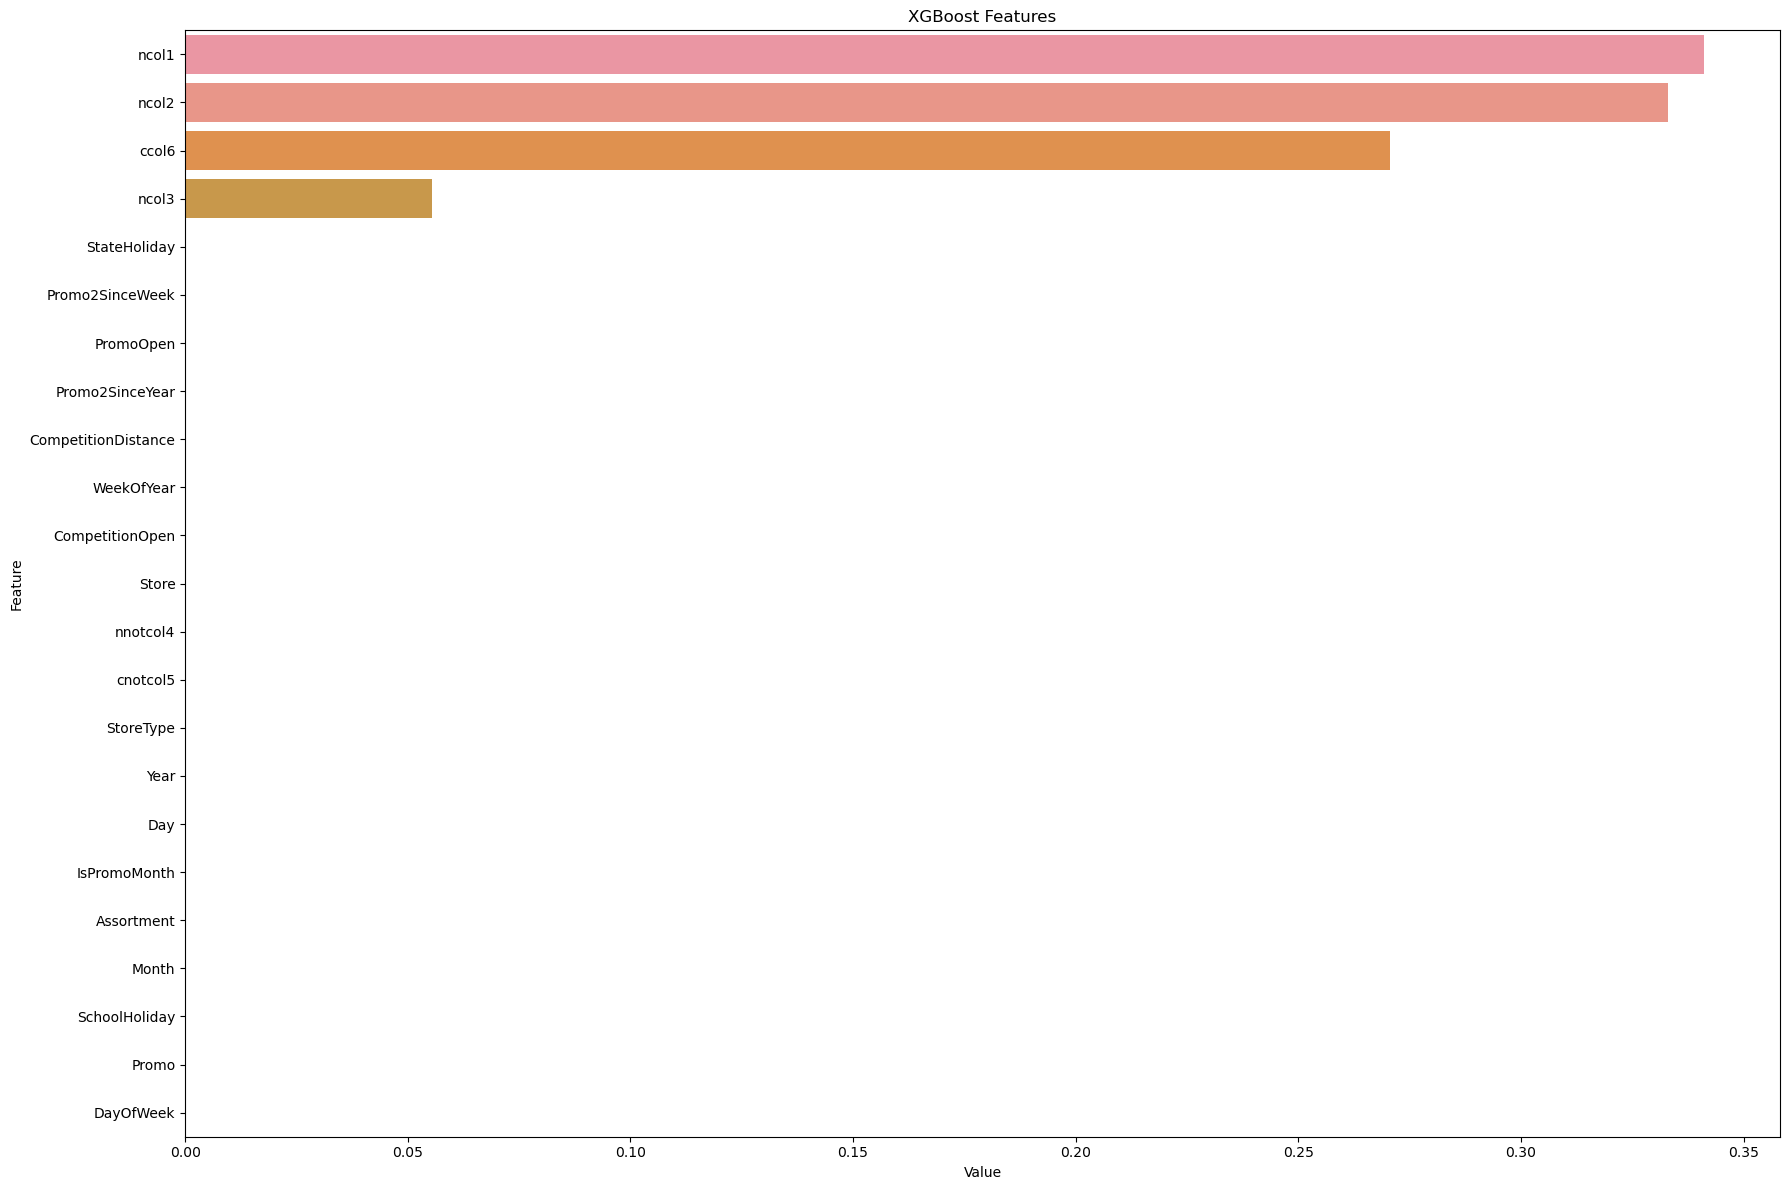

In [75]:
 #make a graph of the feature imporances including their names

feature_imp = pd.DataFrame(sorted(zip(clf_xgb.feature_importances_,X_all.columns)), columns=['Value','Feature'])

plt.figure(figsize=(18, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features')
plt.tight_layout()
plt.show()
